<a href="https://colab.research.google.com/github/Meddhif13/ChallengeData/blob/main/hw/hw1/hw_imdb_text_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import string

# HW Instructions

## Code guideline
This notebook is intended to be executed in a standard **Google Colab** notebook.
https://colab.research.google.com/

The notebook will be executed and evaluated on Google Colab.

## 🚧 Cells
All the cells identified with a 🚧 should be completed, either by a code or an written answer.
You can add as many cells as you want, but in general cells are already in place.


🚧 **TODO** 🚧

*Requires to complete a code (can be completed with optional text cells if you find it relevant).*

or

🚧 **Question** 🚧

*Requires a written answer (can be completed with optional code cells if you find it relevant).*

## 🔴 Test cells
Cells identified with 🔴 should be left untouched and shouldn't return any error.

## Presentation
The overall presentation of the notebook will account in the grading process.
Some advice:
- Give title to your figures.
- Put legends on the figures.
- Comment the figures if they are not self-explanatory.
- Add comment in the code if not self-explanatory.
- Review your notebook before submitting.
- Feel free to add any additional illustration if you find it will bring something.
- Remain as concise as possible when answering written answer, emphasize the important points.

**We cannot debug every notebooks. The notebook should run entirely from the start to the end without any error. If one cell returns an error during the execution, only the cells before the error will be graded.**



# HW Introduction

## Hands on with NLP preprocessing

The goal of this first homework is to introduce the preprocessing steps in NLP. This step is necessary, very valuable but often not emphasized enough.

## Plan

1. Load the data
2. Analyze and clean the text data
3. Format the texts for Deep Learning models and pytorch (i.e. tokenize, etc).

## Notations

Throughout the HW, a text will be called either **document** or **text**.


# I - Data loading

In [58]:
def download_imdb(output_path: str, force_download: bool = False):
    """Save the data to `output_path`."""
    output_path = Path(output_path)
    if (not output_path.is_file()) or force_download:
        gdd.download_file_from_google_drive(
            file_id="1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz",
            dest_path=output_path,
        )
    return

In [59]:
DATA_PATH = "data/imdb_reviews.csv"
download_imdb(output_path=DATA_PATH, force_download=False)

🚧 **TODO** 🚧

Read the file to a Pandas dataframe (the file is stored as a csv). Make sure the "review" field is of dtype `string` and label of dtype `int`.

Hint: https://pandas.pydata.org/docs/user_guide/text.html (you can specify the `dtype` argument of pandas constructor).


In [60]:
df_imdb = pd.read_csv(DATA_PATH, dtype={"review": "string", "label": "int"})

In [61]:
text_column = df_imdb["review"]
label_column = df_imdb["label"]

🔴 **TEST**

In [62]:
assert text_column.dtype == "string"
assert label_column.dtype == int

🚧 **TODO** 🚧

Print some values of the dataframe.
- Print 3 samples of text.
- Print their associated labels.
- Print some statistics of the dataset.



==== 3 First Reviews and Their Labels ====
Review: Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.
Label: 0

Review: This is an example of why the 

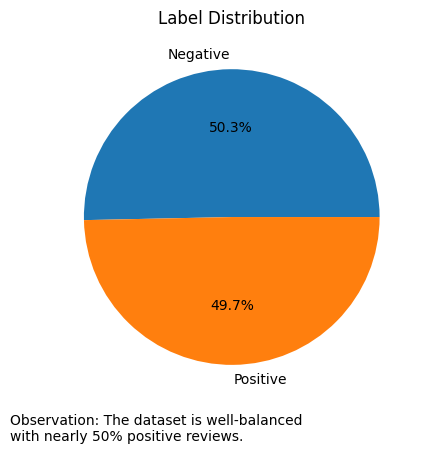

In [63]:
# Print the first 3 reviews and their corresponding labels for inspection
print("==== 3 First Reviews and Their Labels ====")
for review, label in zip(text_column.iloc[:3], label_column.iloc[:3]):
    print(f"Review: {review}\nLabel: {label}\n")  # Display both review and label

# Print basic dataset statistics
print("\n=== Dataset Statistics ===")
print(f"Total number of texts: {len(text_column)}.")  # Total number of reviews
print(f"Average text length: {text_column.apply(len).mean():.2f} characters. [Average review length indicates the need for efficient tokenization.]")  # Average length of reviews
print(f"Percentage of positive texts: {(label_column.mean() * 100):.2f}%")  # Percentage of positive sentiment reviews

# Generate a pie chart for label distribution
label_counts = label_column.value_counts()  # Count occurrences of each label (0 and 1)
fig, ax = plt.subplots()
label_counts.plot(kind='pie',autopct='%1.1f%%',labels=["Negative", "Positive"],title="Label Distribution",ylabel="",ax=ax)
observation_text = "Observation: The dataset is well-balanced\nwith nearly 50% positive reviews."
plt.text(-1.5, -1.5, observation_text, fontsize=10, wrap=True)
plt.show()


## II - Clean and format the data.
For this first TP, we want to focus on very simple tasks.
Therefore, we want to avoid as much as possible rare and uncommon words that will be considered as outliers.

We will try to figure out what kind of cleaning we can perform, by having a look at the data.

The plan for this part will be:
1. Split the strings as a list of words.
2. Find the outliers in the corpus.
3. Propose some methods to clean them.

### 1. Tokenization
First, we will split our texts into words.
Splitting a string into a list of smaller substrings is called **tokenization**, and the substrings are called **tokens**.

The simplest way to tokenize a text is to split it by words, according to whitespaces.

Then, each word encountered in the training set is stored and uniquely identified through an id.



🚧 **Question** 🚧

By doing so, we put a huge emphasis on words within documents.

a) Intuitively, why is it relevant? For instance compare to splitting by character.

b) Cite some methods discussed during the course that rely on word-based representations of documents.

✅ **Answer** ✅

**a) Intuitively, why is it relevant? For instance compare to splitting by character.**
- **Word-Based Tokenization**:
  - Focuses on the linguistic meaning of a document by isolating words.
  - Preserves semantic units that convey meaning (e.g., "great movie" has different semantics than "g r e a t m o v i e").
  - Makes downstream tasks (like frequency counts, embeddings) more efficient and interpretable.

- **Character-Based Tokenization**:
  - Ignores the semantic structure and treats text as a sequence of characters.
  - Can be useful for certain tasks, such as handling rare or out-of-vocabulary words, but generally results in much larger token vocabularies and less interpretability.

**b) Cite some methods discussed during the course that rely on word-based representations of documents.**
- **Bag of Words (BoW)**:
  - Represents documents as a vector of word counts.
  - Simple but effective for many tasks.
- **TF-IDF (Term Frequency-Inverse Document Frequency)**:
  - Word frequencies are weighted by their informativeness across documents.
- **Word Embeddings**:
  - Dense vector representations of words (e.g., Word2Vec, GloVe).
  - Capture semantic similarities between words.
- **Sequence Models**:
  - Models like RNNs and Transformers process sequences of tokens (e.g., words) for tasks like text classification and machine translation.




🚧 **TODO** 🚧

Implement a tokenizer based on whitespace splitting. For now, the tokenizer should only be able to store each unique word found in the dataset.

In [64]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split()  # Splits the text by whitespace

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)  # Tokenize the text into words

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None  # Check if the token is not already in the vocabulary
                if token_not_in_vocab:
                    self.vocab[token] = current_id  # Add the token to the vocabulary with a new ID
                    self.id_to_token[current_id] = token  # Add reverse mapping
                    self.frequencies[current_id] = 0  # Initialize token frequency to 0
                    token_id = current_id
                    current_id += 1  # Increment ID for the next token

                self.frequencies[token_id] += 1  # Increment the frequency of the token

        # Total number of words in vocab.
        self.num_words = len(self.vocab)  # The total number of unique words
        print(f"Built a vocabulary of {self.num_words} words.")


🔴 **TEST**

In [65]:
toy_corpus = ["a cat", "a dog"]
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(toy_corpus)
assert tokenizer.vocab == {"a": 0, "cat": 1, "dog": 2}
assert tokenizer.frequencies == {0: 2, 1: 1, 2: 1}
assert tokenizer.num_words == 3

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 3 words.


🚧 **TODO** 🚧

Fits the tokenizer on the imdb reviews.

In [66]:
# TODO
# Initialize the tokenizer
tokenizer = WhiteSpaceTokenizer()

# Fit the tokenizer on the IMDB reviews
tokenizer.fit(text_column.tolist())


  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 474682 words.


### 2. Noise analysis

🚧 **TODO** 🚧

Print 50 random tokens.

In [67]:
# TODO
import random

# Sample 50 random tokens from the vocabulary
random_tokens = random.sample(list(tokenizer.vocab.keys()), 50)

# Print the random tokens
print("50 Random Tokens:")
for token in random_tokens:
    print(token)


50 Random Tokens:
(communism)
blackened
mistaken.
SEATS:<br
worm-on-human
Carney
movie-watching
turnoff
reinterpretation.<br
Kane\",
McDiarmid)
suffices
series?).
flackering.
Samuel.<br
ENEMY
path,
'Cliffhanger'
Extemporaneous
Kid,
WSJ).<br
Alcohol",
interesting?!
Kennedy's,
episodes..
"Miike"
recently;
Mallet
downplays
yuk).
(IMDB
/>\"Cry
"empty"
chaser,
metallers\"
Midaregumo
"Jo
(1981)
"Kite".
cross!!
"Romanian
Loggia)
\"natural\"
World':
and...you
perforations
yes!!<br
Warner?)
Art's
expedition),


🚧 **QUESTION** 🚧

What do you think of the tokens? Do they look like simple "words" as expected?

Analyze the noise and explain why we got such weird vocabulary.

✅ **Answer** ✅

The tokens do not look like simple "words" as expected. Many tokens include punctuation, special characters, HTML tags, case inconsistencies, and typos (e.g., `endings!!`, `now!!<br`, `Seagul`). This indicates significant noise in the vocabulary.

### **Analysis**
1. **Special Characters and Punctuation**: Tokens include `!!`, `<br>`, and quotes due to lack of preprocessing.
2. **Case Sensitivity**: Words like `Can't` and `can't` are treated differently.
3. **Typos/Encoding Issues**: Tokens like `surpriseÂ?through` show encoding problems.
4. **Complex Tokens**: Delimiters (`/`, `:`) and mixed formats (e.g., `comedy/gangster`) remain unprocessed.

### **Why This Happened**
- **Whitespace-Based Tokenization**: Splitting by spaces preserves formatting, punctuation, and encoding issues.
- **Dataset Style**: Informal reviews include noise like typos, HTML tags, and special characters.
- **Lack of Preprocessing**: No steps taken yet to normalize, clean, or process tokens.

### **Next Steps**
Preprocess tokens by applying:
- Lowercasing.
- Removing punctuation, HTML tags, and encoding artifacts.
- Handling typos and standardizing tokens.

### 3. Cleaning

🚧 **TODO** 🚧

You are going to implement some of the classical cleaning methods.
1. Lower case the string.
2. String normalization, i.e., replace accentuated characters by standard version ("â -> a") (hint: https://stackoverflow.com/a/14121678).
3. Remove non alpha-numeric characters (use Python regex package `re`).
4. Replace numeric characters by the token `'<NUM>'` (use the package `re`).
5. Remove double whitespaces (use the package `re`).


In [68]:
import unicodedata
import re

In [70]:
def preprocess_text(text: str) -> str:
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Normalize accented characters to their standard equivalents
    # (e.g., "Ï" -> "i")
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')

    # Step 3: Remove non-alphanumeric characters (punctuation, symbols, etc.)
    # Except for spaces to preserve word separation
    text = re.sub(r'[^a-zA-Z0-9\s-]', '', text)  # Keep hyphens for compound words like "San-Francisco"
    text = re.sub(r'\s*-\s*', ' ', text)  # Replace hyphens surrounded by spaces


    # Step 4: Replace numbers with the <NUM> token
    text = re.sub(r'\d+', '<NUM>', text)

    # Step 5: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove double whitespaces

    return text


🔴 **TEST**

In [71]:
noisy_text = "Ï   lîved  in    San-Françisco...  ! for 12 years."
clean_text = "i lived in san francisco for <NUM> years"
assert preprocess_text(noisy_text) == clean_text

🚧 **TODO** 🚧

Add column `clean_review` to the dataframe, with the clean text.

Store the `clean_review` column to the variable `clean_column`.

In [72]:
# TODO
# Apply the preprocess_text function to each review in the text_column
df_imdb["clean_review"] = text_column.apply(preprocess_text)

# Store the clean_review column in the clean_column variable
clean_column = df_imdb["clean_review"]

🚧 **TODO** 🚧

Run the tokenizer on the clean text and print 50 random tokens.

In [73]:
# TODO fit the tokenizer with cleaned reviews
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column.tolist())  # clean_column was previously assigned

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 151937 words.


In [74]:
# TODO Print 50 random tokens from the vocabulary
import random

random_tokens = random.sample(list(tokenizer.vocab.keys()), 50)  # Sample 50 random tokens
print("50 Random Tokens from Cleaned Text:")
for token in random_tokens:
    print(token)

50 Random Tokens from Cleaned Text:
rigeur
potty
summoned
strangeonly
ultimtum
manticores
skilfully
cobbled
effectit
henenlotters
aurelius
categorizations
sorpasso
odile
negativepositive
enlivenes
toma
quited
knautzs
dezel
mediating
screenall
overactedbr
hookerbr
watchingit
scen
nealquite
deploys
stevie
singled
networks
picked
feetthose
unsaid
oberons
roled
glaring
zemekis
arousing
nicodemus
batchler
trymane
alwaleed
salma
beastermaster
disenchanting
marek
insightsbr
makeit
concoct


🚧 **Question** 🚧

What do you think of the new tokens? Are they better? What common noise still remain? (Feel free to print more tokens to get a better intuition).

Suggest some methods to improve again the tokenization (at least 2), based on either these results or on something you think we could have done better.

**Answer**

TODO

### ✅ **Answer** ✅

The new tokens are significantly better than the initial noisy tokens:
- **Improvements**: Special characters, numbers, and uppercase inconsistencies have been removed.
- **Remaining Noise**:
  - **Concatenated Words**: Tokens like `overtheyll` and `beautifuland` indicate missing spaces.
  - **Line Break Artifacts**: Tokens like `languagesbr` and `silentsbr` suggest residual HTML tags.
  - **Uncommon/Stretch Words**: Rare words (`cifaretto`) and exaggerated tokens (`looooooonnnnnggggggg`) remain.


### **Suggestions for Improvement**
1. **Handle Concatenated Tokens**:
   - Use regex or pre-defined patterns to split tokens with missing spaces (e.g., `overtheyll` to `over they ll`).

2. **Remove Residual Artifacts**:
   - Further normalize HTML tags or non-alphabetic characters to address remnants like `<br>`.

3. **Normalize Stretched Words**:
   - Use regex to reduce overly stretched tokens (e.g., `looooooonnnnnggggggg` to `long`).

4. **Spell Correction**:
   - Use spell-checking libraries like `SymSpell` to address typos or uncommon terms.

These refinements can ensure cleaner and more meaningful tokens for downstream tasks.


### Tokens analysis


🚧 **TODO** 🚧

Show the frequencies repartition.
This should be a histogram, with 100 bins, with the frequencies on the x axis and the number of words associated to the frequencies on the y axis (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

Use logarithm scale for y.

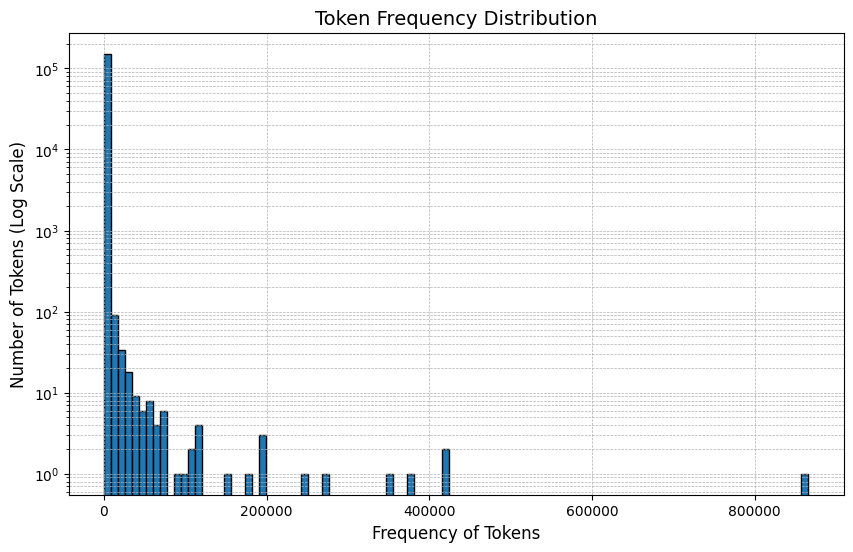

In [75]:
# TODO
# Get token frequencies
token_frequencies = list(tokenizer.frequencies.values())

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(token_frequencies, bins=100, log=True, edgecolor='black')  # Logarithmic y-axis

# Add titles and labels
plt.title("Token Frequency Distribution", fontsize=14)
plt.xlabel("Frequency of Tokens", fontsize=12)
plt.ylabel("Number of Tokens (Log Scale)", fontsize=12)

# Display the plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


🚧 **Question** 🚧

What do you think of the repartition? Explore links with Zipf's law (https://en.wikipedia.org/wiki/Zipf%27s_law). You can add other plots if you think it will help you to understand the distribution.

### ✅ **Answer** ✅

The token frequency distribution follows a **long tail** pattern, as expected in natural language corpora, which aligns with **Zipf's law**:
- **Zipf's Law**: The frequency of a word is inversely proportional to its rank in the frequency table. Common words like "the" or "a" appear very frequently, while most words occur rarely.

#### **Observations**:
1. **Head of Distribution**:
   - A small number of tokens dominate the dataset, likely comprising stopwords and frequent terms.
   
2. **Tail of Distribution**:
   - The vast majority of tokens appear very rarely, often occurring once or twice.

3. **Logarithmic Visualization**:
   - The log scale highlights the disproportionate number of rare tokens compared to frequent ones.


#### **Links to Zipf's Law**:
1. **Commonality of Rare Tokens**:
   - Most tokens are low-frequency, contributing to the tail of the distribution.
   - Rare tokens might include proper nouns, domain-specific terms, or residual noise.

2. **Frequent Tokens**:
   - High-frequency tokens contribute heavily to the overall word count but provide limited unique information.


#### **Further Analysis**:
   - Plot frequency vs. rank on a log-log scale to verify the Zipfian distribution.

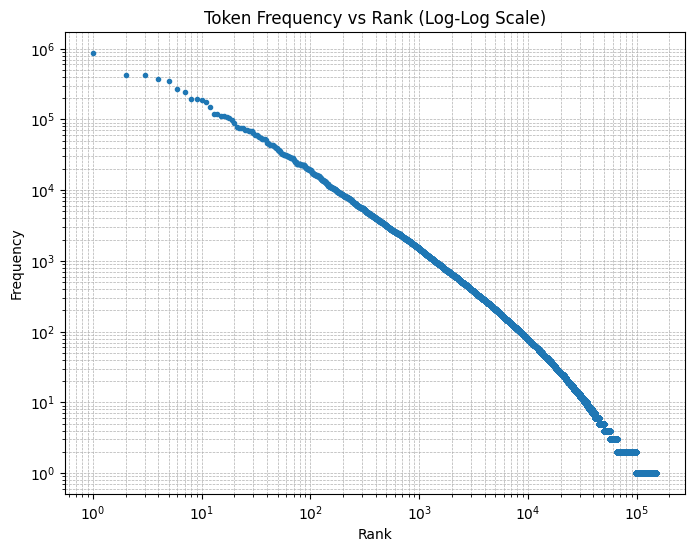

In [76]:
   # Rank tokens by frequency
   sorted_frequencies = sorted(token_frequencies, reverse=True)
   ranks = range(1, len(sorted_frequencies) + 1)

   # Plot on log-log scale
   plt.figure(figsize=(8, 6))
   plt.loglog(ranks, sorted_frequencies, marker="o", markersize=3, linestyle="none")
   plt.title("Token Frequency vs Rank (Log-Log Scale)")
   plt.xlabel("Rank")
   plt.ylabel("Frequency")
   plt.grid(True, which="both", linestyle="--", linewidth=0.5)
   plt.show()

#### **Suggestions**:
- **Stopword Removal:**
High-frequency stopwords may not add much value for downstream tasks.
- **Low-Frequency Filtering:**
Tokens with very low frequencies can be excluded to simplify the vocabulary.

🚧 **TODO** 🚧

Modify the code of the `WhiteSpaceTokenizer` so that it could encode a text into a list of token ids and do the reverse (i.e. decode a list of token ids to a text).

In [77]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        # TODO
        return text.split()  # Split text by whitespace into a list of tokens

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        # TODO
        tokens = self.split_text(text)  # Tokenize the text
        return [self.vocab[token] for token in tokens if token in self.vocab]  # Convert tokens to IDs

    def decode(self, ids: List[int]) -> str:
        # TODO
        """Take a list of token IDs as input and return the reconstructed text."""
        return " ".join([self.id_to_token[token_id] for token_id in ids if token_id in self.id_to_token])


    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)  # Tokenize the text

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None  # Check if token is not already in the vocab
                if token_not_in_vocab:
                    self.vocab[token] = current_id  # Add token to vocab with a unique ID
                    self.id_to_token[current_id] = token  # Add reverse mapping
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)  # Total unique tokens
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [78]:
tokenizer = WhiteSpaceTokenizer()
toy_dataset = ["the cat is in the kitchen", "i have a dog"]
tokenizer.fit(toy_dataset)
text = "i have a kitchen"
assert tokenizer.encode(text) == [5, 6, 7, 4]
assert tokenizer.decode([0, 1, 2, 7, 8]) == "the cat is a dog"

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 9 words.


🚧 **TODO** 🚧 Now fit it on your dataset.

In [79]:
# TODO
# Initialize the tokenizer
tokenizer = WhiteSpaceTokenizer()

# Fit the tokenizer on the cleaned reviews
tokenizer.fit(clean_column.tolist())


  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 151937 words.


🚧 **Question** 🚧
Look at the following code:

In [80]:
tokenizer.encode("the king is in the câstle")

[16, 3664, 57, 39, 16]

a) Does it raise an exception? Explain what is the problem with the above situation.

b) In which real life scenario could such a situation appear?


### ✅ **Answer** ✅

#### **a) Does it raise an exception? What is the problem with the above situation?**
- **No, it does not raise an exception.**
- **The Problem**:
  - The token `cástle` is **not in the vocabulary** because it likely contains an accented character (`á`), which might not have been properly normalized during preprocessing.
  - As a result, it is ignored during encoding, and no corresponding token ID is generated for it.


#### **b) In which real-life scenario could such a situation appear?**
1. **Multilingual Text**:
   - In a dataset containing text from multiple languages, words with accents or diacritics might be overlooked if preprocessing does not handle them properly.

2. **Noisy Data**:
   - User-generated content, such as social media posts or reviews, often contains inconsistent use of characters (e.g., `cástle` vs `castle`).

3. **Incomplete Preprocessing**:
   - If text normalization steps (e.g., removing accents) are skipped or improperly applied, such mismatches can occur.

4. **OOV Words**:
   - Out-of-vocabulary (OOV) words, like rare proper nouns or domain-specific terms, can also lead to such situations.


### **Suggestions to Avoid the Issue**:
1. **Ensure Proper Normalization**:
   - During preprocessing, convert accented characters to their standard equivalents (e.g., `á -> a`).
   
2. **Handle OOV Words**:
   - Implement a mechanism to map unknown tokens to a special `<UNK>` token to avoid silent omissions.


🚧 **TODO** 🚧

Propose a simple modification of the tokenizer code such that it doesn't raise an exception anymore. It should handle the presence of any unknown token.

The following code should't raise any exception.

In [83]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

        # Add a special <UNK> token for unknown tokens
        self.unk_token = "<UNK>"
        self.unk_token_id = 0
        self.vocab[self.unk_token] = self.unk_token_id
        self.id_to_token[self.unk_token_id] = self.unk_token

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split()  # Split text by whitespace into a list of tokens

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        tokens = self.split_text(text)  # Tokenize the text
        return [self.vocab.get(token, self.unk_token_id) for token in tokens]  # Convert tokens to IDs or <UNK>

    def decode(self, ids: List[int]) -> str:
        """Take a list of token IDs as input and return the reconstructed text."""
        return " ".join([self.id_to_token.get(token_id, self.unk_token) for token_id in ids])

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = len(self.vocab)  # Start IDs after the <UNK> token
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)  # Tokenize the text

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None  # Check if token is not already in the vocab
                if token_not_in_vocab:
                    self.vocab[token] = current_id  # Add token to vocab with a unique ID
                    self.id_to_token[current_id] = token  # Add reverse mapping
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)  # Total unique tokens
        print(f"Built a vocabulary of {self.num_words} words.")

# Re-initialize the tokenizer
tokenizer = WhiteSpaceTokenizer()

# Re-fit the tokenizer on the cleaned reviews
tokenizer.fit(clean_column.tolist())

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 151938 words.


🔴 **TEST**

In [84]:
allowed_characters = (string.ascii_uppercase + string.digits).replace(" ", "")
for _ in range(1000):
    word_that_do_not_exist = "".join(random.choices(allowed_characters, k=100))
    encoding = tokenizer.encode(f"the king is in the {word_that_do_not_exist}")
    assert tokenizer.decode(encoding) == "the king is in the <UNK>"

🚧 **Question** 🚧

Look for online resources about tokenization.
- Explain the concept of "subword tokenization".
- Explain how the BPE algorithm works (high level description).

### ✅ **Answer** ✅

#### **1. Subword Tokenization**
- **Concept**:
  - Subword tokenization is a hybrid approach that splits text into smaller units than words but larger than characters.
  - It addresses the limitations of word-level and character-level tokenization:
    - **Word-Level**: Cannot handle out-of-vocabulary (OOV) words.
    - **Character-Level**: Leads to longer sequences, increasing computational cost.
  - Instead, subword tokenization breaks rare words into meaningful subword units (e.g., "unbelievable" → ["un", "believable"]).
  - Frequently occurring words remain intact, while uncommon words are split.

- **Benefits**:
  - Handles OOV words gracefully.
  - Reduces the vocabulary size while maintaining semantic richness.
  - Frequently used subwords are retained, ensuring efficiency and meaningful representation.



#### **2. Byte Pair Encoding (BPE) Algorithm**
- **High-Level Description**:
  - BPE is a data compression technique adapted for tokenization.
  - It creates subword units by merging the most frequent pair of symbols (characters or subwords) iteratively.

- **Steps**:
  1. **Start with Characters**:
     - Treat every character in the corpus as an initial token.
  2. **Count Frequencies**:
     - Calculate the frequency of all consecutive token pairs in the corpus.
  3. **Merge the Most Frequent Pair**:
     - Find the most frequent pair of tokens and merge them into a new token.
     - For example, given "h e l l o" and "h e l l", merge "l l" to create "ll".
  4. **Repeat**:
     - Update the corpus with the new token and repeat the process for a predefined number of merges.

- **Example**:
  - Input Corpus: `["low", "lower", "newest", "widest"]`
  - Iterations:
    1. Count pairs: `("lo", "ow", "we", "st", etc.)`
    2. Merge the most frequent: `["low", "low", "newe", "wides"]`
    3. Repeat.

- **Outcome**:
  - The resulting subwords are optimized to represent the corpus efficiently.

- **Advantages of BPE**:
  - Reduces the vocabulary size.
  - Ensures OOV words can be represented as a combination of subwords.
  - Adapts well to a wide variety of languages.



## III - DataLoading

This final part aims at making your dataset compatible with PyTorch.

### Text representation

Since we plan to work with PyTorch, we need to work with `tensors`. But since a text is only composed of strings, we need to find some numerical representations for the text.

The most basic method is to represent a text by list of tokens. We already used a simple WhiteSpace tokenizer earlier to analyze our texts before cleaning. Now we will use it to *represent* the texts.

### Dataset for PyTorch
We will be working wtth PyTorch most of the time.
A good practice is to always iterate through a `torch.utils.data.DataLoader`, coupled with `torch.utils.data.Dataset`.

🚧 **TODO** 🚧

We will construct our custom `Dataset` class, that should be fully compatible with the PyTorch API. According to the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), such a dataset should implement at least three methods, `__init__`, `__len__`, `__getitem__`. Complete the following code such that the dataset yields a list of texts.

Requirements:
1. The dataset class should read the data from the csv_file stored in `DATA_PATH`.
2. The dataset should output the raw text, without any cleaning.

In [87]:
from torch.utils.data import Dataset
import pandas as pd


class IMDBDataset(Dataset):
    def __init__(self, file_path: str):
        """
        Initializes the dataset by loading the data from a CSV file.
        Args:
            file_path (str): Path to the CSV file containing the dataset.
        """
        self.data = pd.read_csv(file_path)  # Read the CSV file into a Pandas DataFrame

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)  # Total number of rows in the DataFrame

    def __getitem__(self, idx: int):
        """
        Retrieves the text and label at the given index.
        Args:
            idx (int): Index of the desired sample.
        Returns:
            tuple: (str, int) The text and label from the dataset.
        """
        text = self.data.iloc[idx]["review"]  # Retrieve the review text
        label = self.data.iloc[idx]["label"]  # Retrieve the label
        return text, label  # Return both the text and the label


🔴 **TEST**

In [88]:
imdb_dataset = IMDBDataset(file_path=DATA_PATH)
text, label = imdb_dataset[0]
assert text == text_column[0]
assert label == label_column[0]

### DataLoader for PyTorch

Now that the dataset is ready, we should be able to iterate through it. This is done with a `DataLoader`.

The `DataLoader` also has some handy functionnalities:
1. Batch iteration.
2. Collate function.

The collate function corresponds to the argument `collate_fn` of the constructor of `torch.utils.data.DataLoader`.

This function is applied on the fly to each sample of the dataset.

Our `IMDBDataset` only outputs raw texts. During the iteration through the `DataLoader`, we would like to:
1. Clean the dataset with our cleaning function `preprocess_text`.
2. Convert the text to a list of tokens.
3. The `DataLoader`, for a batch size of `N`, should yield a dictionnary `{"token_ids": ..., "labels": ...,}` with `"token_ids"` corresponding to a list of `N` lists of tokens ids, and `"labels"` to a list of size `N` with the corresponding labels.

🚧 **TODO** 🚧

Write the `collate_fn` function so that the above requirements are satisfied (i.e., clean and tokenize).

In [89]:
# TODO
def collate_fn(batch):
    """
    Custom collate function to preprocess and tokenize the dataset.
    Args:
        batch (list): A batch of samples, where each sample is a tuple (text, label).
    Returns:
        dict: A dictionary containing:
              - "token_ids": A list of lists, where each list represents the tokenized IDs for a text.
              - "labels": A list of labels corresponding to the texts.
    """
    token_ids = []  # List to store tokenized IDs
    labels = []  # List to store labels

    for text, label in batch:
        # Clean the text using the preprocess_text function
        cleaned_text = preprocess_text(text)

        # Tokenize the cleaned text using the tokenizer
        tokens = tokenizer.encode(cleaned_text)

        # Append the token IDs and label
        token_ids.append(tokens)
        labels.append(label)

    return {"token_ids": token_ids, "labels": labels}


In [90]:
from torch.utils.data import DataLoader

# Create the DataLoader
dataloader = DataLoader(
    dataset=imdb_dataset,  # Your dataset instance
    batch_size=32,  # Define the batch size
    collate_fn=collate_fn,  # Use the custom collate function
    shuffle=True  # Shuffle the data for training
)

# Test the DataLoader
for batch in dataloader:
    print(batch["token_ids"])
    print(batch["labels"])
    break


[[427, 17, 8707, 58, 230, 8, 228, 830, 22, 10964, 202, 28, 333, 17, 9, 113, 123918, 57, 149672, 29, 113, 3329, 144, 64, 583, 86, 8, 2373, 13319, 42, 560, 206, 81, 9699, 202, 24846, 216, 144, 660, 727, 85, 1485, 2110, 401, 304, 112, 31, 85, 17, 758, 22, 8, 745, 6380, 69, 5525, 296, 13190, 7445, 42, 5, 8, 1042, 43816, 29588, 47, 17, 1282, 22, 17, 5855, 123944, 202, 51657, 68, 58, 516, 547, 85, 38, 81, 1575, 560, 14093, 1057, 99, 69, 820, 2306, 17, 4104, 153, 21738, 42, 69, 820, 151, 85, 4275, 2542, 202, 202, 6315, 17, 662, 665, 1485, 149673, 243, 29151, 294, 940, 105, 243, 8728, 2788, 5995, 5252, 6308, 627, 42, 7852, 149674, 820, 17, 1842, 115, 586, 358, 202, 202, 28, 2842, 145, 99, 300, 23371, 85, 7033, 2914, 315, 243, 1575, 42, 733, 227, 40, 149675, 1100, 55, 304, 152, 335, 144, 148, 99, 9428, 75, 17, 662, 665, 1485, 2588, 42, 630, 22, 17, 12684, 1842], [96, 9, 2190, 16, 17, 633, 144, 10, 2036, 833, 239, 78, 5981, 67, 85, 576, 85, 14556, 1697, 5273, 10, 17, 6591, 81, 732, 1067, 14750, 

🔴 **TEST**

In [91]:
for batch_size in range(1, 10):
    dataloader = DataLoader(
        dataset=imdb_dataset, batch_size=batch_size, collate_fn=collate_fn
    )
    for batch in dataloader:
        token_ids = batch["token_ids"]
        labels = batch["labels"]
        assert len(token_ids) == batch_size
        assert len(labels) == batch_size
        assert isinstance(token_ids[0][0], int)
        assert (isinstance(labels[0], int)) or isinstance(labels[0], np.int64)
        break

🚧 **Question** 🚧

Write a concise summary on what you learned with this lab.

### ✅ **Answer** ✅
#### **Summary of Learnings from the Lab**

In this lab, I gained a practical understanding of text preprocessing and tokenization for Natural Language Processing (NLP) with hands on practice and trial and error.
Referring back to the lecture notes and external resources I took away numerous concepts such as:
1. **Text Preprocessing**:
   - Implemented text cleaning techniques such as lowercasing, normalization, and removal of non-alphanumeric characters.
   - Understood the importance of preprocessing for creating clean and consistent text data for machine learning models.

2. **Custom Tokenizer**:
   - Built a custom tokenizer that tokenizes text into tokens, encodes them into numerical IDs, and handles unknown tokens with a special `<UNK>` token.
   - Learned the importance of subword tokenization for handling out-of-vocabulary words.

3. **Dataset Integration with PyTorch**:
   - Created a custom PyTorch `Dataset` class to handle raw text and labels.
   - Used `torch.utils.data.DataLoader` with a `collate_fn` to process and batch data dynamically during training.

4. **Data Representation**:
   - Explored efficient ways to represent textual data numerically for deep learning.
   - Applied a pipeline combining preprocessing, tokenization, and batching.

This lab provided a solid foundation for handling text data in NLP tasks and integrating it with PyTorch for further model training.
